In [1]:
import numpy as np
import os
from plotly.subplots import make_subplots
from plotly import graph_objs as go
import plotly.figure_factory as ff

In [2]:
fig_template = go.layout.Template()
fig_template.layout = {
    'template': 'simple_white+presentation',
    'autosize': False,
    'width': 800,
    'height': 600,
    # 'opacity': 0.2,
    'xaxis': {
        'ticks': 'inside',
        'mirror': 'ticks',
        'linewidth': 1.5+0.5,
        'tickwidth': 1.5+0.5,
        'ticklen': 6,
        'showline': True,
        'showgrid': False,
        'zerolinecolor': 'white',
        },
    'yaxis': {
        'ticks': 'inside',
        'mirror': 'ticks',
        'linewidth': 1.5+0.5,
        'tickwidth': 1.5+0.5,
        'ticklen': 6,
        'showline': True,
        'showgrid': False,
        'zerolinecolor': 'white'
        },
    'font':{'family':'mathjax',
            'size': 22,
            }
}

In [3]:
wire_radius = 12.5e-6; distance = 100e-6; wire_current = 5; mu_freeSpace = 4*np.pi*1e-7; chi = -2.2e-5
outer_linear_density = 5; inner_linear_density = 5; point_separation = 2e-6

# outer_points = np.linspace(wire_radius, distance, outer_linear_density); inner_points = np.linspace(0,wire_radius,inner_linear_density,endpoint=False)
outer_points = np.arange(wire_radius, distance, point_separation); inner_points = np.arange(0,wire_radius,point_separation)

In [4]:
# Customizing the number of points for a cirle
init_angle = 0; final_angle = 2*np.pi; point_distance = np.pi/4.0
init_circle_points = 1; point_increament = 2

# about_angle = np.array([init_angle,final_angle,point_distance])
about_angle_1 = np.array([init_angle,final_angle,init_circle_points,point_increament])

In [5]:
x_linear_point = np.unique(np.concatenate((-outer_points[::-1],-inner_points[::-1][:-1],inner_points,outer_points)))
y_linear_point = x_linear_point

In [6]:
# Important Modfications for calculating phi from (x,y)
(np.arctan(-1/-1)+np.pi)*180/np.pi,(2*np.pi+np.arctan(-1/1))*180/np.pi,(np.arctan(1/-1)+np.pi)*180/np.pi

(225.0, 315.0, 135.0)

In [7]:
def xy_phi(x,y):
    if x==0.0:
      angle = np.arctan(y*np.inf)
    # as shown above
    elif x<0 and y<0:
      angle = np.arctan(y/x)+np.pi
    elif x>0 and y<0:
      angle = np.arctan(y/x)+2*np.pi
    elif x<0 and y>0:
      angle = np.arctan(y/x)+np.pi
    else:
      angle = np.arctan(y/x)
    return angle

In [8]:
def circular_grid(x,wire_radius,about_angle):
  radius  = x[np.where(x>=0)[0]]
  # init,final,separation = about_angle
  init,final,init_p,incre = about_angle
  xy_circle_grid = []
  for i in range(radius.shape[0]):
    angles = np.linspace(init,final,int(init_p),endpoint=False)
    init_p += incre
    # if radius[i]==0:
    #     angles = [0]
    # else:
    #     angles = np.arange(init,final,(wire_radius/radius[i])*separation)
    xy_circle_grid.append(np.array([radius[i]*np.cos(angles),radius[i]*np.sin(angles)]))
  return xy_circle_grid

In [9]:
def MagField(current,mu,chi,wire_radius,x,y):
  field = np.ones((x.shape[0],y.shape[0]))
  for i in range(x.shape[0]):
    for j in range(y.shape[0]):
      radius = np.sqrt(x[i]**2+y[j]**2)
      if radius<=wire_radius:
        field[i,j] = None
      else:
        if y[j]<(-wire_radius):
          mu_below = mu*(1+chi)
          field[i,j] = (mu_below*current)/(2*np.pi*np.sqrt(x[i]**2+y[j]**2))
        else:
          field[i,j] = (mu*current)/(2*np.pi*np.sqrt(x[i]**2+y[j]**2))
  return field

In [10]:
def Quiver_MagField(current,mu,chi,wire_radius,x_linear,about_angle):
  circular_field_xy = []; circular_quiver_xy = []; circular_field = []
  xy_points = circular_grid(x_linear,wire_radius,about_angle)
  for k in range(len(xy_points)):
    x = xy_points[k][0,:]; y = xy_points[k][1,:]
    _field_xy = []; _quiver_xy = []; _field = []
    for i in range(x.shape[0]):
      j=i
      radius = np.sqrt(x[i]**2+y[j]**2)
      if radius<=wire_radius:
        field = None
        field_xy = np.array([None,None])
        quiver_xy = np.array([x[i],y[j]])
        _field_xy.append(field_xy); _quiver_xy.append(quiver_xy); _field.append(field)
      else:
        angle=xy_phi(x[i],y[j])
        if y[j]<(-wire_radius):
          mu_below = mu*(1+chi)
          field = (mu_below*current)/(2*np.pi*np.sqrt(x[i]**2+y[j]**2))
          field_xy = np.array([field*np.cos(angle), field*np.sin(angle)])
          quiver_xy = np.array([x[i],y[j]])
          _field_xy.append(field_xy); _quiver_xy.append(quiver_xy); _field.append(field)
        else:
          field = (mu*current)/(2*np.pi*np.sqrt(x[i]**2+y[j]**2))
          field_xy = np.array([field*np.cos(angle), field*np.sin(angle)])
          quiver_xy = np.array([x[i],y[j]])
          _field_xy.append(field_xy); _quiver_xy.append(quiver_xy); _field.append(field)
    circular_field_xy.append(_field_xy); circular_quiver_xy.append(_quiver_xy); circular_field.append(_field)
  return circular_field,circular_field_xy,circular_quiver_xy

In [11]:
# circular_field,field_xy,quiver_xy = Quiver_MagField(current=wire_current,mu=mu_freeSpace,chi=chi,wire_radius=wire_radius,x_linear=x_linear_point,about_angle=about_angle)
circular_field,field_xy,quiver_xy = Quiver_MagField(current=wire_current,mu=mu_freeSpace,chi=chi,wire_radius=wire_radius,x_linear=x_linear_point,about_angle=about_angle_1)
mag_field = MagField(current=wire_current,mu=mu_freeSpace,chi=chi,wire_radius=wire_radius,x=x_linear_point,y=y_linear_point)

In [12]:
def Simul_Quiver_MagField(current,mu,chi,wire_radius,x,y):
    _field_xy = []; _quiver_xy = []; _field = []
    for i in range(x.shape[0]):
        angle=xy_phi(x[i],y[i])
        if y[i]<(-wire_radius):
          mu_below = mu*(1+chi)
          field = (mu_below*current)/(2*np.pi*np.sqrt(x[i]**2+y[i]**2))
          field_xy = np.array([field*np.cos(angle), field*np.sin(angle)])
          quiver_xy = np.array([x[i],y[i]])
          print(f'angle : {(np.arctan(y[i]/x[i])+2*np.pi)*180/np.pi}')
          _field_xy.append(field_xy); _quiver_xy.append(quiver_xy); _field.append(field)
        else:
            print('Check y values')
    return _field,_field_xy,_quiver_xy

In [13]:
x_simul_heatmap = np.linspace(50,35,4)*1e-6;  x_simul_quiver = np.array([47,46.3,45.5,44,42.98,47.7,38.65,36.87])*1e-6       # y
y_simul_heatmap = np.linspace(15,35,6)*(-1e-6); y_simul_quiver = np.array([18.5,20,22,25,26.6,16.5,32.5,34.5])*(-1e-6)       # z
exp_angles = np.array([156.92,156.6,154.78,152.87,151.64,161.27,141.2,138.08])*(np.pi/180)
relative_exp_angles = exp_angles - np.pi/2

In [14]:
X,Y = np.meshgrid(x_simul_heatmap,y_simul_heatmap)
mu_below = mu_freeSpace*(1+chi)
magField_simul = (mu_below*wire_current)/(2*np.pi*np.sqrt(X**2+Y**2))

In [15]:
simul_quiver_field,simul_field_xy,simul_quiver_xy = Simul_Quiver_MagField(current=wire_current,mu=mu_freeSpace,chi=chi,wire_radius=wire_radius,x=x_simul_quiver,y=y_simul_quiver)

angle : 338.51455668293664
angle : 336.63732413055106
angle : 334.19546760005284
angle : 330.3955492539951
angle : 328.246945369855
angle : 340.9188855710464
angle : 319.9402023455347
angle : 316.9019352289362


In [16]:
exp_field_quiver_x = simul_quiver_field*np.cos(relative_exp_angles)
exp_field_quiver_y = simul_quiver_field*np.sin(relative_exp_angles)
exp_field_quiver_xy = np.vstack((exp_field_quiver_x,exp_field_quiver_y))

In [17]:
# folder_path = os.getcwd()

# filename = 'heatmap_data_circular.npz'
# total_path = os.path.join(folder_path,filename)
# np.savez(total_path,x_points=x_linear_point,y_points=y_linear_point,magField = mag_field)

# filename = 'heatmap_data_rectangular.npz'
# total_path = os.path.join(folder_path,filename)
# np.savez(total_path,x_points=x_simul_heatmap,y_points=y_simul_heatmap,magField = magField_simul)

# filename = 'quiver_data_rectangular.npz'
# total_path = os.path.join(folder_path,filename)
# np.savez(total_path,simul_xy_points=simul_quiver_xy,simul_magField = simul_field_xy,exp_field_quiver_xy=exp_field_quiver_xy)

In [18]:
# !pip install -U kaleido

In [20]:
a=100*magField_simul
np.max(a[~np.isnan(a)]),np.min(a[~np.isnan(a)])

(2.6260708823639933, 1.6384277948335781)

# New section

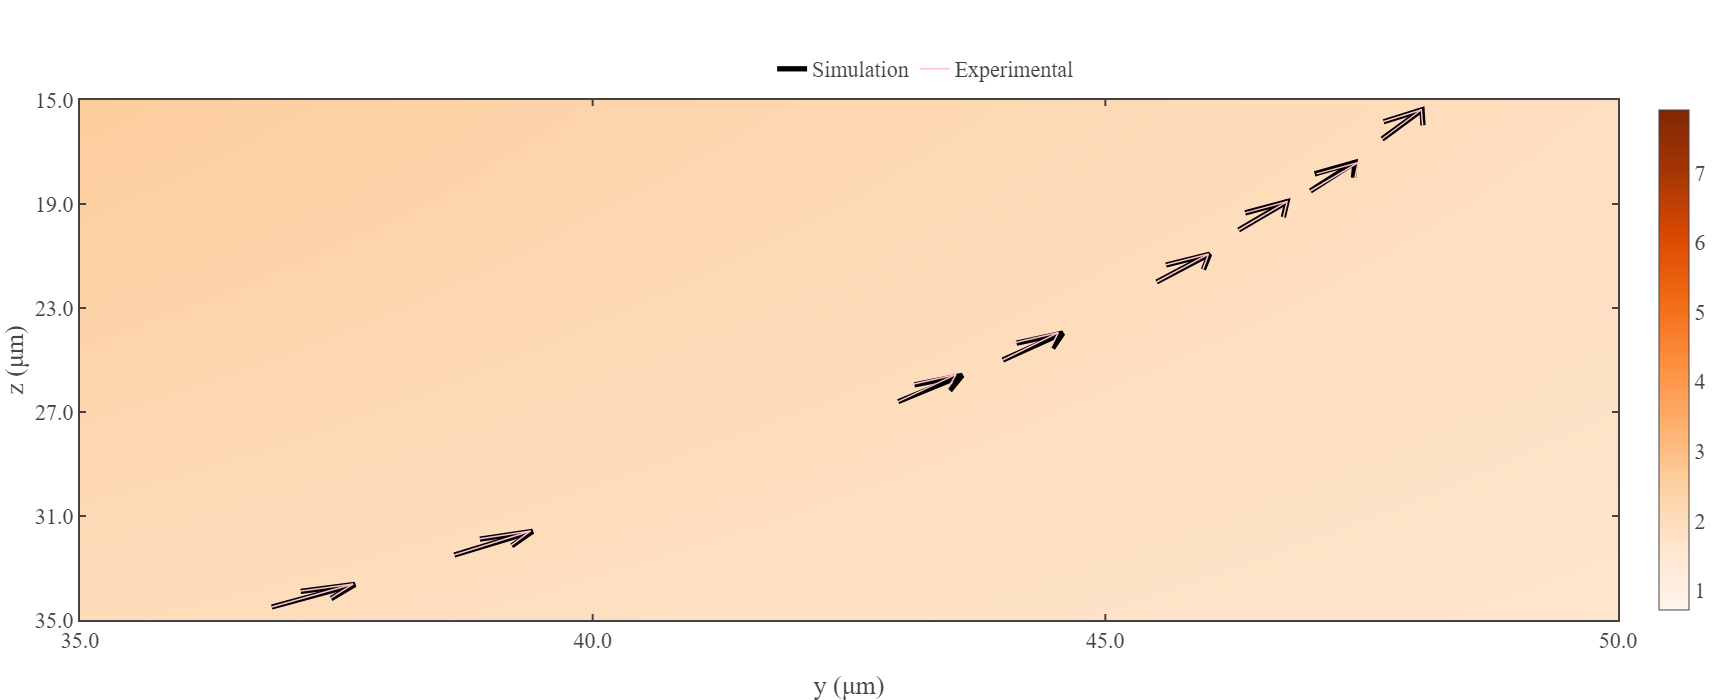

In [37]:
fig = go.Figure()
micron = 1
# Heatmap
fig.add_trace(go.Contour(x=x_simul_heatmap/micron,y=y_simul_heatmap/micron,z=100*magField_simul,contours_coloring='heatmap',
                                connectgaps = False,line_smoothing=1,colorbar=dict(title='Magnetic Field (arb. unit)',titleside='right'),coloraxis='coloraxis'))
fig.update_layout(
    coloraxis={
        'cmin': 0.7178591115100118,
        'cmax': 7.905694150420948, 'colorscale':'Oranges'    
    }
)
fig.update_traces(line_width=0)
# fig.update_traces(colorscale='Bluered')

# Quiver
for i in range(0,len(simul_quiver_xy)):
    x = simul_quiver_xy[i][0]; y = simul_quiver_xy[i][1]
    radius = np.sqrt(x**2+y**2)
    if np.round(radius,8)>wire_radius:
        _x = [x/micron]; _y = [y/micron]
        u = [-simul_field_xy[i][1]/micron]; v =[ simul_field_xy[i][0]/micron]
        if _x[0]==simul_quiver_xy[0][0]:
            quiver_trace = ff.create_quiver(_x, _y, u, v, scale=0.00006, arrow_scale=0.5, scaleratio=1.0, angle=np.pi/9, line=dict(width=5.3, color='black'),name='Simulation').data[0]
            fig.add_trace(quiver_trace)
        else:
            quiver_trace = ff.create_quiver(_x, _y, u, v, scale=0.00006, arrow_scale=0.5, scaleratio=1.0, angle=np.pi/9, line=dict(width=5.3, color='black'),showlegend=False).data[0]
            fig.add_trace(quiver_trace)

# Quiver
for i in range(0,len(simul_quiver_xy)):
    x = simul_quiver_xy[i][0]; y = simul_quiver_xy[i][1]
    radius = np.sqrt(x**2+y**2)
    if np.round(radius,8)>wire_radius:
        _x = [x/micron]; _y = [y/micron]
        u = [ exp_field_quiver_x[i]/micron]; v =[ exp_field_quiver_y[i]/micron]
        if _x[0]==simul_quiver_xy[0][0]:
            quiver_trace = ff.create_quiver(_x, _y, u, v, scale=0.00006, arrow_scale=0.5, scaleratio=1.0, angle=np.pi/9, line=dict(width=1.5, color='pink'),name='Experimental').data[0]
            fig.add_trace(quiver_trace)
        else:
            quiver_trace = ff.create_quiver(_x, _y, u, v, scale=0.00006, arrow_scale=0.5, scaleratio=1.0, angle=np.pi/9, line=dict(width=1.5, color='pink'),showlegend=False).data[0]
            fig.add_trace(quiver_trace)


fig.update_layout(template=fig_template, title = None,width=800, height=700)
fig.update_xaxes(title = 'y (&mu;m)',range = [x_simul_heatmap[-1]/micron,x_simul_heatmap[0]/micron],ticks="inside")
fig.update_yaxes(title = 'z (&mu;m)', range = [y_simul_heatmap[-1]/micron,y_simul_heatmap[0]/micron],ticks="inside")

x_tick_str = []; y_tick_str = []
[x_tick_str.append(str(np.round(x,2))) for x in (x_simul_heatmap/1e-6)]
[y_tick_str.append(str(np.round(y,2))) for y in -(y_simul_heatmap/1e-6)]

fig.update_layout(
    xaxis = dict(tickmode = 'array',tickvals = x_simul_heatmap,ticktext = x_tick_str),
    yaxis = dict(tickmode = 'array',tickvals = y_simul_heatmap,ticktext = y_tick_str)
)
# fig.update_layout(showlegend=False)
fig.update_layout(legend=dict(
    orientation="h",
    yanchor="top",
    y=1.1,
    xanchor="left",
    x=0.45,
    title_font_family="Times New Roman",
))
# fig.write_html('rectangular_view.html')
# fig.write_image('rectangular_view.pdf')
fig.show()

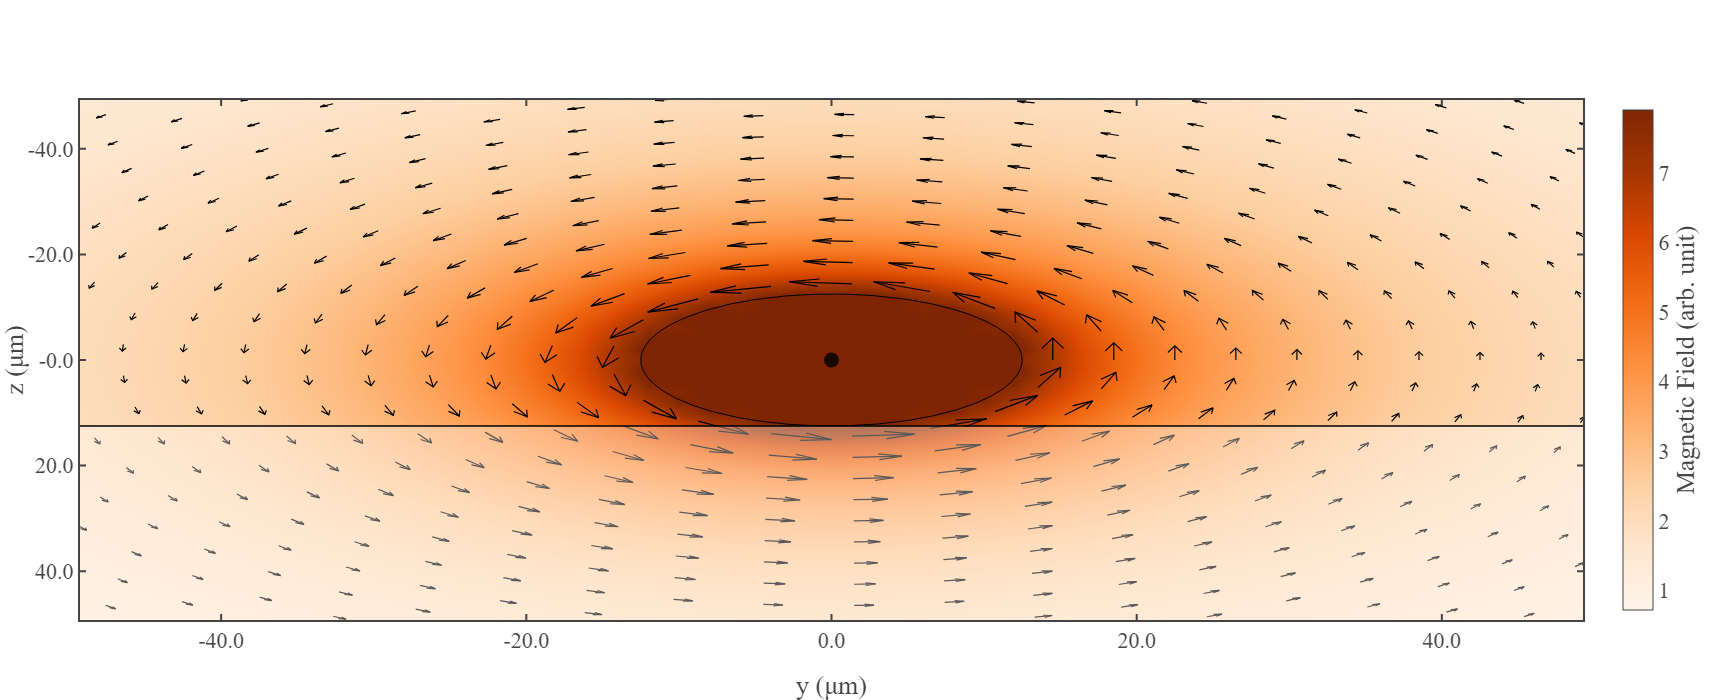

In [36]:
fig = go.Figure()
# Heatmap
fig.add_trace(go.Contour(x=x_linear_point,y=y_linear_point,z=100*mag_field.T,contours_coloring='heatmap',
                                connectgaps = True,line_smoothing=1,colorbar=dict(title='Magnetic Field (arb. unit)',titleside='right'),colorscale='Oranges',reversescale=False))
fig.update_traces(line_width=0)

# Quiver
for i in range(0,len(quiver_xy),2):
    for j in range(0,len(quiver_xy[i]),1):
        x = quiver_xy[i][j][0]; y = quiver_xy[i][j][1]
        radius = np.sqrt(x**2+y**2)
        if np.round(radius,8)>wire_radius:
            # print(i,j,radius)
            _x = [x]; _y = [y]
            u = [-field_xy[i][j][1]]; v =[ field_xy[i][j][0]]
            quiver_trace = ff.create_quiver(_x, _y, u, v, scale=0.00006, arrow_scale=0.5, scaleratio=1.0, angle=np.pi/9, line=dict(width=1.2, color='black')).data[0]
            fig.add_trace(quiver_trace)

# Inner Circle
fig.add_trace(go.Scatter(x=wire_radius*np.cos(np.linspace(0,2*np.pi,1000,endpoint=False)), y=wire_radius*np.sin(np.linspace(0,2*np.pi,1000,endpoint=False)),
                         mode='lines', line=dict(color='black', width=1),fill = 'tozeroy',fillcolor = 'rgba(102,17,0, 0.15)'))

# # Outer Circles
# [fig.add_trace(go.Scatter(x=radius*np.cos(np.linspace(0,2*np.pi,1000)), y=radius*np.sin(np.linspace(0,2*np.pi,1000)),
#                          mode='lines', line=dict(color='yellow', width=0.7))) for radius in outer_points]

# Other Ornamentations
fig.add_trace(go.Scatter(x=[0], y=[0], mode='markers', marker_size=15, marker=dict(color='black',opacity=0.8)))
fig.add_trace(go.Scatter(x=x_linear_point, y=-wire_radius*np.ones(x_linear_point.shape[0]), mode='lines', line=dict(color='black',width=1.5),fill=None))
fig.add_trace(go.Scatter(x=x_linear_point, y=-y_linear_point[-1]*np.ones(x_linear_point.shape[0]), mode='lines', marker=dict(color='grey'),
                         fill='tonexty',fillcolor = 'rgba(255, 255, 255, 0.35)'))

circular_x = np.array([-40,-20,0,20,40])*1e-6
circular_y = np.array([-40,-20,-0,20,40])*1e-6

x_tick_str = []; y_tick_str = []
[x_tick_str.append(str(x)) for x in (circular_x/1e-6)]
[y_tick_str.append(str(y)) for y in -(circular_y/1e-6)]

fig.update_layout(
    xaxis = dict(tickmode = 'array',tickvals = circular_x,ticktext = x_tick_str),
    yaxis = dict(tickmode = 'array',tickvals = circular_y,ticktext = y_tick_str)
)

fig.update_layout(template=fig_template, title = None,width=800, height=700)
fig.update_xaxes(title = 'y (&mu;m)',range = np.array([x_linear_point[0],x_linear_point[-1]])/2.0)
fig.update_yaxes(title = 'z (&mu;m)', range = np.array([y_linear_point[0],y_linear_point[-1]])/2.0)
fig.update_layout(showlegend=False)
# fig.write_html('circular_view.html')
fig.show()

In [23]:
a=100*mag_field
np.max(a[~np.isnan(a)]),np.min(a[~np.isnan(a)])

(7.905694150420948, 0.7178591115100118)